# Import of required libraries and modules

In [ ]:
!pip install sentence_transformers
!pip install nearpy rtree
import pandas as pd
from timeit import timeit
import numpy as np
import time as tm
import re
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from scipy.spatial import KDTree
from rtree import index

In [ ]:
df = pd.read_csv("dataset2.csv")
df= df.head()
df

,Scientist,Awards,Education
0,Atta ur Rehman Khan,10,\n\nAtta ur Rehman Khan has a PhD in Computer ...
1,Wil van der Aalst,8,\nWil van der Aalst obtained an MSc (1985) and...
2,Scott Aaronson,1,\n\nScott Aaronson received his bachelor's deg...
3,Rediet Abebe,2,\n\nRediet Abebe is an Ethiopian computer scie...
4,Hal Abelson,14,"\n\nHal Abelson is a computer scientist, educa..."


In [ ]:
ind = df.loc[:, ['Scientist', 'Awards']].values
edc = df.loc[:, ['Education']].values


# KDTree Implementation

In [ ]:
from scipy.spatial import KDTree
df = pd.read_csv("scientists_data.csv")

# Extract the columns Surname, Awards, and Education
ind = df.loc[:, ['surname', 'awards', 'publications']].values
edc = df.loc[:, ['education']].values

# Initialize the SentenceTransformer model for encoding education texts
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode the education texts using the SentenceTransformer model
embeddings = model.encode(edc.flatten())

# Convert the embeddings to a numpy array
embeddings = np.array(embeddings)

# Create a KD tree index for the Surname and Awards
surnames = ind[:, 0]
awards = ind[:, 1].astype(int)
publications = ind[:, 2]
surname_values = {surname: i for i, surname in enumerate(surnames)}
value_surnames = {value: surname for surname, value in surname_values.items()}
data = [(surname_values[surname], award, publication) for surname, award, publication in zip(surnames, awards, publications)]
kdtree = KDTree(data)

""" LSH index for the education embeddings, for a dataset with 250 entries
 8 to 16 bits are adequate for a reasonable balance between accuracy and efficiency.
 Also more tables generally provide better accuracy but increase the query time.
"""

# Create an LSH index for the education embeddings
dim = embeddings.shape[1]
num_bits = 16
num_tables = 4

# Create LSH hashes
lsh_hashes = []
for _ in range(num_tables):
    lsh_hashes.append(RandomBinaryProjections('lsh', num_bits))

# Create the LSH engine
lsh_engine = Engine(dim, lshashes=lsh_hashes)

# Define the query conditions
letter_interval = ('A', 'H')
awards_threshold = 4
education_similarity_threshold = 0.6

# Add the filtered scientists' education embeddings to the LSH engine
filtered_scientists = []
for idx, (surname, award) in enumerate(zip(surnames, awards)):
    if letter_interval[0] <= surname[0] <= letter_interval[1] and award > awards_threshold:
        filtered_scientists.append((surname, award))
        lsh_engine.store_vector(embeddings[idx], idx)

# Perform the similarity query using the LSH index on filtered scientists
similar_scientists = []
for idx, (surname, award) in enumerate(filtered_scientists):
    query_embedding = embeddings[idx]
    query_results = lsh_engine.neighbours(query_embedding)

    # Retrieve the similar scientists' indices from the query results
    similar_indices = [result[1] for result in query_results if result[0][0] < education_similarity_threshold]

    # Filter the similar scientists based on the education similarity threshold
    similar_scientists.extend([(value_surnames[i], awards[i]) for i in similar_indices if (value_surnames[i], awards[i]) not in similar_scientists])


# Print the filtered scientists
print("Filtered Scientists:")
for surname, award in filtered_scientists:
    print(f"Surname: {surname}, Awards: {award}")
print()

# Print the similar scientists based on education
print("Similar Scientists based on Education:")
for surname, award in similar_scientists:
    print(f"Surname: {surname}, Awards: {award}")




Filtered Scientists:
Surname: Allen, Awards: 6
Surname: Anthony, Awards: 6
Surname: Bader, Awards: 6
Surname: Bell, Awards: 8
Surname: Brooks, Awards: 5
Surname: Caspersen, Awards: 8
Surname: Comer, Awards: 8
Surname: Croft, Awards: 8
Surname: Dean, Awards: 6
Surname: Diffie, Awards: 6
Surname: Dongarra, Awards: 15
Surname: Draper, Awards: 6
Surname: Edelman, Awards: 7
Surname: Engelbart, Awards: 7
Surname: Foley, Awards: 6
Surname: Fischer, Awards: 7
Surname: Goldwasser, Awards: 11
Surname: Graham, Awards: 5
Surname: Hennessy, Awards: 6
Surname: Hinton, Awards: 9
Surname: Hoare, Awards: 7
Surname: Hopcroft, Awards: 8
Surname: Hopper, Awards: 9

Similar Scientists based on Education:
Surname: Diffie, Awards: 6
Surname: Allen, Awards: 6
Surname: Anthony, Awards: 6
Surname: Bader, Awards: 6
Surname: Bell, Awards: 8
Surname: Brooks, Awards: 5


In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# Step 1: Apply t-SNE on the embeddings to get 3D coordinates.
tsne = TSNE(n_components=3, perplexity=40, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# Extract the 2D coordinates for all scientists, filtered scientists, and similar scientists
all_coords = embeddings_3d
filtered_indices = [surname_values[surname] for surname, _ in filtered_scientists]
similar_indices = [surname_values[surname] for surname, _ in similar_scientists]
filtered_coords = embeddings_3d[filtered_indices]
similar_coords = embeddings_3d[similar_indices]

# Create a new column to indicate the type: 'all', 'filtered', or 'similar'
df['type'] = 'all'
df.loc[filtered_indices, 'type'] = 'filtered'
df.loc[similar_indices, 'type'] = 'similar'

# Visualization using Plotly Express in 3D
fig = px.scatter_3d(df, x=embeddings_3d[:, 0], y=embeddings_3d[:, 1], z=embeddings_3d[:, 2], color='type', opacity=0.8)
fig.update_layout(title="t-SNE 3D visualization of Scientists' Education Embeddings")
fig.show()


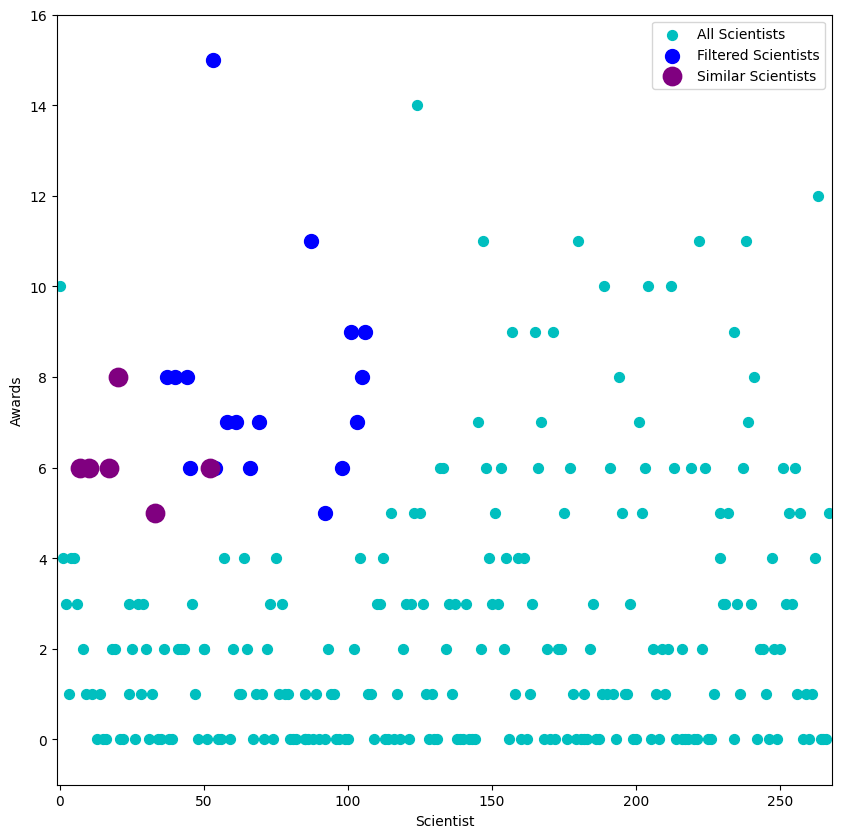

In [ ]:
import matplotlib.pyplot as plt

def visualize_kdtree_and_lsh(data, filtered_scientists, similar_scientists):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot all scientists
    all_x = [point[0] for point in data]
    all_y = [point[1] for point in data]
    ax.scatter(all_x, all_y, color='c', s=50, label='All Scientists')

    # Highlight the scientists filtered for range query (blue circles)
    filtered_x = [surname_values[surname] for surname, _ in filtered_scientists]
    filtered_y = [award for _, award in filtered_scientists]
    ax.scatter(filtered_x, filtered_y, color='blue', s=100, label='Filtered Scientists')

    # Highlight the scientists found similar by LSH (red circles with yellow edges)
    similar_x = [surname_values[surname] for surname, _ in similar_scientists]
    similar_y = [award for _, award in similar_scientists]
    ax.scatter(similar_x, similar_y, color='purple', s=150, linewidths=2, label='Similar Scientists')

    plt.xlim(-1, max(all_x)+1)
    plt.ylim(-1, max(all_y)+1)
    ax.set_xlabel('Scientist')
    ax.set_ylabel('Awards')
    plt.legend()
    plt.show()

# Visualize
visualize_kdtree_and_lsh(data, filtered_scientists, similar_scientists)


# Quad tree implementation

### Quadtree class

In [ ]:
# Define the Point and Node classes for QuadTree
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Node:
    def __init__(self, point, data):
        self.point = point
        self.data = data

# Define the QuadTree class
class QuadTree:
    def __init__(self, boundary):
        self.boundary = boundary
        self.points = []
        self.capacity = 4
        self.top_left = None
        self.top_right = None
        self.bottom_left = None
        self.bottom_right = None

    def insert(self, point, data):
        if not self.boundary_contains(point):
            return False

        if len(self.points) < self.capacity:
            self.points.append(Node(point, data))
            return True

        if self.top_left is None:
            self.subdivide()

        if self.top_left.insert(point, data):
            return True
        if self.top_right.insert(point, data):
            return True
        if self.bottom_left.insert(point, data):
            return True
        if self.bottom_right.insert(point, data):
            return True

        return False

    def query(self, range_boundary):
        points_in_range = []
        if not self.intersects(range_boundary):
            return points_in_range

        for point in self.points:
            if range_boundary_contains(range_boundary, point.point):
                points_in_range.append(point.data)

        if self.top_left is not None:
            points_in_range += self.top_left.query(range_boundary)
            points_in_range += self.top_right.query(range_boundary)
            points_in_range += self.bottom_left.query(range_boundary)
            points_in_range += self.bottom_right.query(range_boundary)

        return points_in_range

    def subdivide(self):
        x_mid = (self.boundary[0] + self.boundary[2]) / 2
        y_mid = (self.boundary[1] + self.boundary[3]) / 2

        self.top_left = QuadTree([self.boundary[0], self.boundary[1], x_mid, y_mid])
        self.top_right = QuadTree([x_mid, self.boundary[1], self.boundary[2], y_mid])
        self.bottom_left = QuadTree([self.boundary[0], y_mid, x_mid, self.boundary[3]])
        self.bottom_right = QuadTree([x_mid, y_mid, self.boundary[2], self.boundary[3]])

    def boundary_contains(self, point):
        return (
            self.boundary[0] <= point.x <= self.boundary[2]
            and self.boundary[1] <= point.y <= self.boundary[3]
        )

    def intersects(self, range_boundary):
        return (
            self.boundary[0] < range_boundary[2]
            and self.boundary[1] < range_boundary[3]
            and self.boundary[2] > range_boundary[0]
            and self.boundary[3] > range_boundary[1]
        )

def range_boundary_contains(range_boundary, point):
    return (
        range_boundary[0] <= point.x <= range_boundary[2]
        and range_boundary[1] <= point.y <= range_boundary[3]
    )

In [ ]:
# Read the dataset from the CSV file
df = pd.read_csv("dataset2.csv")

# Extract the columns 'Scientist', 'Awards', and 'Education'
ind = df.loc[:, ['Scientist', 'Awards']].values
edc = df.loc[:, ['Education']].values

# Initialize the SentenceTransformer model for encoding education texts
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode the education texts using the SentenceTransformer model
embeddings = model.encode(edc.flatten())

# Convert the embeddings to a numpy array
embeddings = np.array(embeddings)

# Convert the surnames to a numeric value for QuadTree indexing
surname_values = {surname: i for i, surname in enumerate(sorted(set(surnames)))}

# Create the QuadTree boundary based on max awards and the number of unique surnames
quadtree_boundary = [0, 0, len(surname_values), np.max(awards)]
quadtree = QuadTree(quadtree_boundary)

# Insert data points into the QuadTree
for idx, (surname, award) in enumerate(zip(surnames, awards)):
    point = Point(surname_values[surname], award)
    quadtree.insert(point, (surname, award))

# Create an LSH index for the education embeddings
dim = embeddings.shape[1]
num_bits = 16
num_tables = 4

# Create LSH hashes
lsh_hashes = []
for _ in range(num_tables):
    lsh_hashes.append(RandomBinaryProjections('lsh', num_bits))

# Create the LSH engine
lsh_engine = Engine(dim, lshashes=lsh_hashes)

# Define the query conditions
letter_interval = ('A', 'G')
awards_threshold = 10
education_similarity_threshold = 0.2

# Add the filtered scientists' education embeddings to the LSH engine
filtered_scientists = []
for idx, (surname, award) in enumerate(zip(surnames, awards)):
    if letter_interval[0] <= surname[0] <= letter_interval[1] and award > awards_threshold:
        filtered_scientists.append((surname, award))
        lsh_engine.store_vector(embeddings[idx], idx)

# Perform the similarity query using the LSH index on filtered scientists
similar_scientists = []
for idx, (surname, award) in enumerate(filtered_scientists):
    query_embedding = embeddings[idx]
    query_results = lsh_engine.neighbours(query_embedding)

    # Retrieve the similar scientists' indices from the query results
    similar_indices = [result[1] for result in query_results if result[0][0] < education_similarity_threshold]

    # Filter the similar scientists based on the education similarity threshold
    similar_scientists.extend([(surnames[i], awards[i]) for i in similar_indices if (surnames[i], awards[i]) not in similar_scientists])


# Print the filtered scientists
print("Filtered Scientists:")
for surname, award in filtered_scientists:
    print(f"Surname: {surname}, Awards: {award}")
print()

# Print the similar scientists based on education
print("Similar Scientists based on Education:")
for surname, award in similar_scientists:
    print(f"Surname: {surname}, Awards: {award}")


Filtered Scientists:
Surname: Alfred Aho, Awards: 12
Surname: Frances E. Allen, Awards: 19
Surname: Cecilia R. Aragon, Awards: 11
Surname: David F. Bacon, Awards: 11
Surname: Gordon Bell (born 1934), Awards: 15
Surname: Cecilia Berdichevsky (1925, Awards: 12
Surname: Barry Boehm, Awards: 12
Surname: Corrado Böhm, Awards: 17
Surname: Grady Booch, Awards: 11
Surname: Andrew Booth, Awards: 11
Surname: Anita Borg (1949, Awards: 13
Surname: Edwin Catmull, Awards: 13
Surname: Gregory Chaitin, Awards: 15
Surname: Edgar F. Codd (1923, Awards: 13
Surname: Andries van Dam, Awards: 14
Surname: Christopher J. Date, Awards: 19
Surname: Edsger W. Dijkstra, Awards: 12
Surname: Charles Stark Draper (1901, Awards: 12
Surname: Adam Dunkels, Awards: 11
Surname: Annie Easley, Awards: 11
Surname: Alan Edelman, Awards: 13
Surname: Douglas Engelbart, Awards: 13
Surname: Barbara Engelhardt, Awards: 12
Surname: Andrey Ershov, Awards: 21
Surname: Christopher Riche Evans, Awards: 15
Surname: Edward Felten, Award

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# Step 1: Apply t-SNE on the embeddings to get 3D coordinates.
tsne = TSNE(n_components=3, perplexity=40, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# Extract the 2D coordinates for all scientists, filtered scientists, and similar scientists
all_coords = embeddings_3d
filtered_indices = [surname_values[surname] for surname, _ in filtered_scientists]
similar_indices = [surname_values[surname] for surname, _ in similar_scientists]
filtered_coords = embeddings_3d[filtered_indices]
similar_coords = embeddings_3d[similar_indices]

# Create a new column to indicate the type: 'all', 'filtered', or 'similar'
df['type'] = 'all'
df.loc[filtered_indices, 'type'] = 'filtered'
df.loc[similar_indices, 'type'] = 'similar'

# Visualization using Plotly Express in 3D
fig = px.scatter_3d(df, x=embeddings_3d[:, 0], y=embeddings_3d[:, 1], z=embeddings_3d[:, 2], color='type', opacity=0.8)
fig.update_layout(title="t-SNE 3D visualization of Scientists' Education Embeddings")
fig.show()


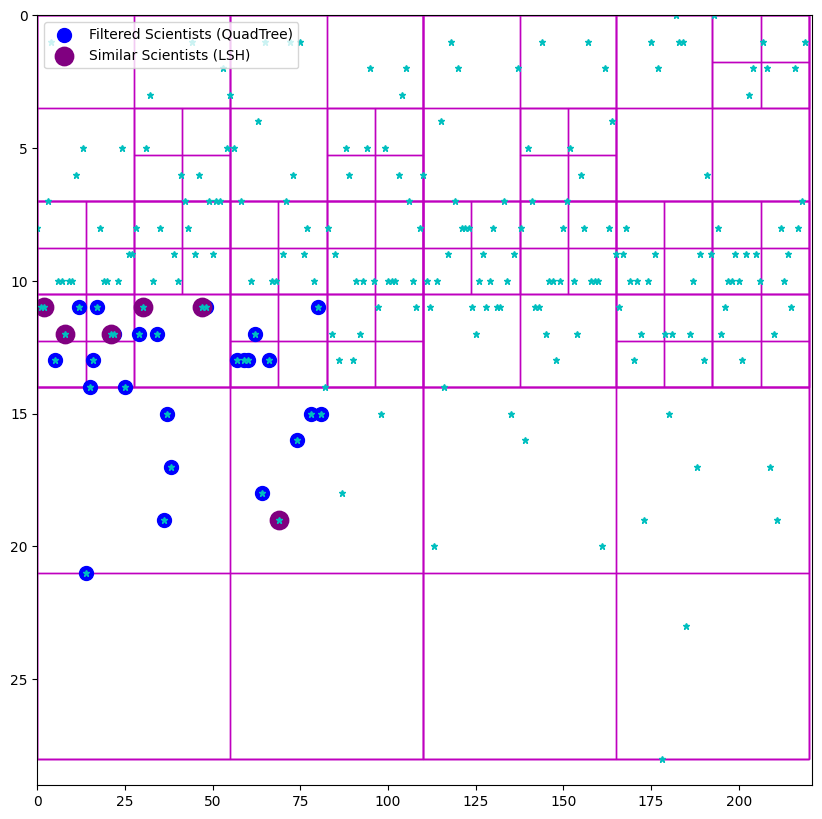

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def quadtree_visualisation(ax, qt):

    rect = patches.Rectangle((qt.boundary[0], qt.boundary[1]),
                             qt.boundary[2] - qt.boundary[0],
                             qt.boundary[3] - qt.boundary[1],
                             linewidth=1, edgecolor='m', facecolor='none')
    ax.add_patch(rect)


    for node in qt.points:
        ax.plot(node.point.x, node.point.y, 'c*', markersize=5)

    # Draw the boundaries of the subdivisions
    if qt.top_left is not None:
        quadtree_visualisation(ax, qt.top_left)
        quadtree_visualisation(ax, qt.top_right)
        quadtree_visualisation(ax, qt.bottom_left)
        quadtree_visualisation(ax, qt.bottom_right)


def quadtree_plus_lsh(quadtree, filtered_scientists, similar_scientists):
    fig, ax = plt.subplots(figsize=(10, 10))

    quadtree_visualisation(ax, quadtree)

    # Highlight the scientists filtered by QuadTree (blue circles)
    filtered_x = [surname_values[surname] for surname, _ in filtered_scientists]
    filtered_y = [award for _, award in filtered_scientists]
    ax.scatter(filtered_x, filtered_y, color='blue', s=100, label='Filtered Scientists (QuadTree)')

    # Highlight the scientists found similar by LSH (red circles with yellow edges)
    similar_x = [surname_values[surname] for surname, _ in similar_scientists]
    similar_y = [award for _, award in similar_scientists]
    ax.scatter(similar_x, similar_y, color='purple', s=150, linewidths=2, label='Similar Scientists (LSH)')

    plt.xlim(0, quadtree.boundary[2]+1)
    plt.ylim(0, quadtree.boundary[3]+1)
    plt.gca().invert_yaxis()  # Invert Y-axis to start (0,0) at the top-left
    plt.legend(loc='upper left')
    plt.show()

# Visualize
quadtree_plus_lsh(quadtree, filtered_scientists, similar_scientists)


# Range tree

In [ ]:
!pip install bintrees-2.0.3-py2.py3-none-any.whl

In [ ]:
!pip install sortedcontainers
!pip install rangetree

In [ ]:
from rangetree import RangeTree

class MyRangeTree:
    def __init__(self):
      """
      serves as a wrapper that extends the functionality of the RangeTree class
      to handle tuple entries (Surname, Award) and enables efficient range
      queries based on both attributes.
      """
      self._tree = RangeTree()._tree

      # This is done to leverage the existing implementation of the RangeTree
      # class while adding custom functionality to handle tuple entries
      # (Surname, Award) in the insert method.

    def insert(self, entry, *args, **kwargs):
        # Custom insertion to handle tuple entry (Surname, Award)
        # create a key using a combination of 'Surname'
        # and 'Award' that uniquely identifies each scientist
        key = (entry[0], entry[1])

        self._tree.insert(key, entry)

    def find(self, x1, x2):
        return self._tree.find(x1, x2)


# Read the dataset from the CSV file
df = pd.read_csv("dataset2.csv")

# Extract the columns 'Scientist', 'Awards', and 'Education'
ind = df.loc[:, ['Scientist', 'Awards']].values
edc = df.loc[:, ['Education']].values

# Initialize the SentenceTransformer model for encoding education texts
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode the education texts using the SentenceTransformer model
embeddings = model.encode(edc.flatten())

# Convert the embeddings to a numpy array
embeddings = np.array(embeddings)

# Create a list of tuples containing Scientist names and their corresponding Award values
scientists_awards = list(zip(ind[:, 0], ind[:, 1].astype(int)))

# Create a custom RangeTree for'Surnames' and 'Awards' attributes
my_tree = MyRangeTree()
for scientist_idx, (surname, award) in enumerate(scientists_awards):
    my_tree.insert((surname, award), surname, scientist_idx)  # Insert both 'Surname' and 'Award' as the entry


# Create an LSH index for the education embeddings
dim = embeddings.shape[1]  # Dimension of the embeddings
num_bits = 16  # Number of bits for LSH hashing
num_tables = 4  # Number of LSH tables

# Create LSH hashes
lsh_hashes = []
for _ in range(num_tables):
    lsh_hashes.append(RandomBinaryProjections('lsh', num_bits))

# Create the LSH engine
lsh_engine = Engine(dim, lshashes=lsh_hashes)

# Define the query conditions
letter_interval = ('A', 'G')
awards_threshold = 10
education_similarity_threshold = 0.2

# Add the filtered scientists' education embeddings to the LSH engine
filtered_scientists = []
for idx, (surname, award) in enumerate(scientists_awards):
    if letter_interval[0] <= surname[0] <= letter_interval[1] and award > awards_threshold:
        filtered_scientists.append((surname, award))
        lsh_engine.store_vector(embeddings[idx], idx)

# Perform the similarity query using the LSH index on filtered scientists
similar_scientists = []
for idx, (surname, award) in enumerate(filtered_scientists):
    query_embedding = embeddings[idx]
    query_results = lsh_engine.neighbours(query_embedding)

    # Retrieve the similar scientists' indices from the query results
    similar_indices = [result[1] for result in query_results if result[0][0] < education_similarity_threshold]

    # Filter the similar scientists based on the education similarity threshold
    similar_scientists.extend([scientists_awards[i] for i in similar_indices if scientists_awards[i] not in similar_scientists])


# Print the filtered scientists
print("Filtered Scientists:")
for surname, award in filtered_scientists:
    print(f"Surname: {surname}, Awards: {award}")
print()

# Print the similar scientists based on education
print("Similar Scientists based on Education:")
for surname, award in similar_scientists:
    print(f"Surname: {surname}, Awards: {award}")


In [ ]:
import matplotlib.pyplot as plt

def visualize_rangetree(data, filtered_scientists, similar_scientists):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot all scientists
    all_x = [point[0] for point in data]
    all_y = [point[1] for point in data]
    ax.scatter(all_x, all_y, color='c', s=50, label='All Scientists')

    # Highlight the scientists filtered for range query (blue circles)
    filtered_x = [point[0] for point in filtered_scientists]
    filtered_y = [point[1] for point in filtered_scientists]
    ax.scatter(filtered_x, filtered_y, color='blue', s=100, label='Filtered Scientists')

    # Highlight the scientists found similar by LSH (red circles with yellow edges)
    similar_x = [point[0] for point in similar_scientists]
    similar_y = [point[1] for point in similar_scientists]
    ax.scatter(similar_x, similar_y, color='purple', s=150, linewidths=2, label='Similar Scientists')

    plt.xlim(-1, max(all_x)+1)
    plt.ylim(-1, max(all_y)+1)
    ax.set_xlabel('Scientist')
    ax.set_ylabel('Awards')
    plt.legend()
    plt.show()

# Visualization
data = [(surname_values[surname], award) for surname, award in scientists_awards]
visualize_rangetree(data, filtered_scientists, similar_scientists)


## R-trees implementation

In [ ]:
from rtree import index

# Read the dataset from the CSV file
df = pd.read_csv("dataset2.csv")

# Extract the columns 'Scientist', 'Awards', and 'Education'
ind = df.loc[:, ['Scientist', 'Awards']].values
edc = df.loc[:, ['Education']].values

# Initialize the SentenceTransformer model for encoding education texts
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode the education texts using the SentenceTransformer model
embeddings = model.encode(edc.flatten())

# Convert the embeddings to a numpy array
embeddings = np.array(embeddings)

# Convert the surnames to a numeric value for R-tree indexing
surname_values = {surname: i for i, surname in enumerate(sorted(set(surnames)))}

# Create a single R-tree index for both 'Surname' and 'Awards'
rtree_idx = index.Index()

# Insert data points into the R-tree
for idx, (surname, award) in enumerate(zip(surnames, awards)):
    rtree_idx.insert(idx, (surname_values[surname], award, surname_values[surname], award))

# Adjust the surname range to find the valid range
start_surnames = sorted([s for s in surname_values.keys() if s.startswith(letter_interval[0])])
end_surnames = sorted([s for s in surname_values.keys() if s.startswith(letter_interval[1])])

if not start_surnames or not end_surnames:
    raise ValueError("No surnames found for the specified letter interval!")

surname_range = (surname_values[start_surnames[0]], surname_values[end_surnames[-1]])
award_range = (awards_threshold, max(awards))

# Use the R-tree's intersection method to find the indices of scientists that fit the criteria
filtered_indices = list(rtree_idx.intersection((surname_range[0], award_range[0], surname_range[1], award_range[1])))
filtered_scientists = [ind[i] for i in filtered_indices]

# Create an LSH index for the education embeddings
dim = embeddings.shape[1]
num_bits = 16
num_tables = 4

# Create LSH hashes
lsh_hashes = []
for _ in range(num_tables):
    lsh_hashes.append(RandomBinaryProjections('lsh', num_bits))

# Create the LSH engine
lsh_engine = Engine(dim, lshashes=lsh_hashes)

# Define the query conditions (same as before)
letter_interval = ('A', 'G')
awards_threshold = 10
education_similarity_threshold = 0.2

# Add the filtered scientists' education embeddings to the LSH engine (same as before)
filtered_scientists = []
for idx, (surname, award) in enumerate(zip(surnames, awards)):
    if letter_interval[0] <= surname[0] <= letter_interval[1] and award > awards_threshold:
        filtered_scientists.append((surname, award))
        lsh_engine.store_vector(embeddings[idx], idx)

# Perform the similarity query using the LSH index on filtered scientists (same as before)
similar_scientists = []
for idx, (surname, award) in enumerate(filtered_scientists):
    query_embedding = embeddings[idx]
    query_results = lsh_engine.neighbours(query_embedding)

    # Retrieve the similar scientists' indices from the query results
    similar_indices = [result[1] for result in query_results if result[0][0] < education_similarity_threshold]

    # Filter the similar scientists based on the education similarity threshold
    similar_scientists.extend([(value_surnames[i], awards[i]) for i in similar_indices if (value_surnames[i], awards[i]) not in similar_scientists])


# Print the filtered scientists (same as before)
print("Filtered Scientists:")
for surname, award in filtered_scientists:
    print(f"Surname: {surname}, Awards: {award}")
print()

# Print the similar scientists based on education (same as before)
print("Similar Scientists based on Education:")
for surname, award in similar_scientists:
    print(f"Surname: {surname}, Awards: {award}")


Filtered Scientists:
Surname: Alfred Aho, Awards: 12
Surname: Frances E. Allen, Awards: 19
Surname: Cecilia R. Aragon, Awards: 11
Surname: David F. Bacon, Awards: 11
Surname: Gordon Bell (born 1934), Awards: 15
Surname: Cecilia Berdichevsky (1925, Awards: 12
Surname: Barry Boehm, Awards: 12
Surname: Corrado Böhm, Awards: 17
Surname: Grady Booch, Awards: 11
Surname: Andrew Booth, Awards: 11
Surname: Anita Borg (1949, Awards: 13
Surname: Edwin Catmull, Awards: 13
Surname: Gregory Chaitin, Awards: 15
Surname: Edgar F. Codd (1923, Awards: 13
Surname: Andries van Dam, Awards: 14
Surname: Christopher J. Date, Awards: 19
Surname: Edsger W. Dijkstra, Awards: 12
Surname: Charles Stark Draper (1901, Awards: 12
Surname: Adam Dunkels, Awards: 11
Surname: Annie Easley, Awards: 11
Surname: Alan Edelman, Awards: 13
Surname: Douglas Engelbart, Awards: 13
Surname: Barbara Engelhardt, Awards: 12
Surname: Andrey Ershov, Awards: 21
Surname: Christopher Riche Evans, Awards: 15
Surname: Edward Felten, Award

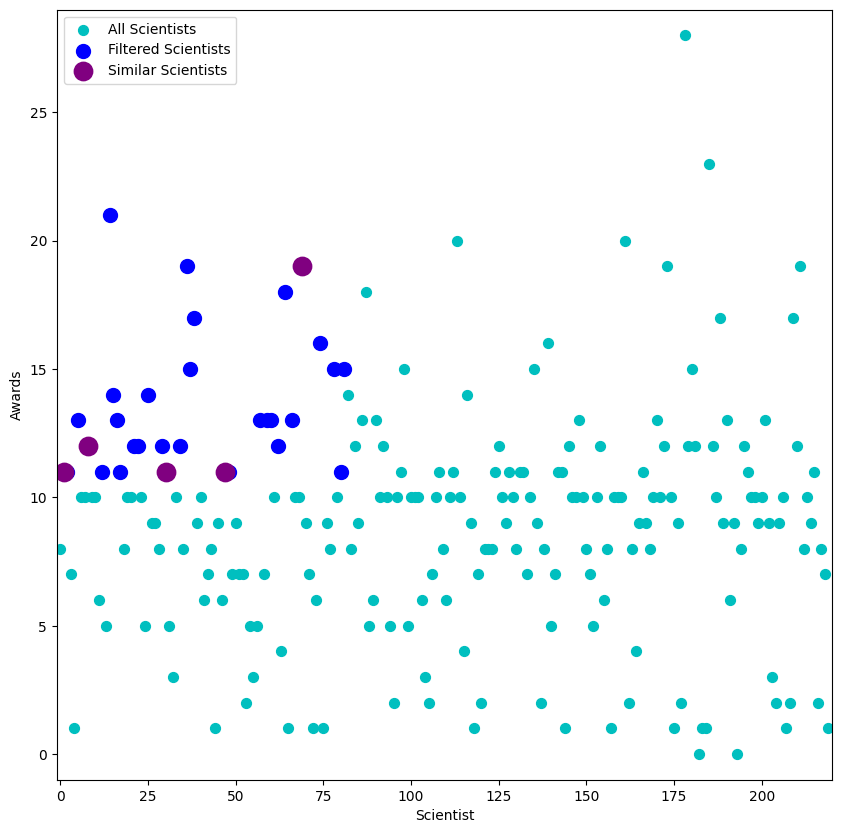

In [ ]:
import matplotlib.pyplot as plt

def visualize_rtree(all_data, filtered_scientists, similar_scientists):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot all scientists
    all_x = [point[0] for point in all_data]
    all_y = [point[1] for point in all_data]
    ax.scatter(all_x, all_y, color='c', s=50, label='All Scientists')

    # Highlight the scientists filtered for range query (blue circles)
    filtered_x = [surname_values[point[0]] for point in filtered_scientists]
    filtered_y = [point[1] for point in filtered_scientists]
    ax.scatter(filtered_x, filtered_y, color='blue', s=100, label='Filtered Scientists')

    # Highlight the scientists found similar by LSH (red circles with yellow edges)
    similar_x = [surname_values[point[0]] for point in similar_scientists]
    similar_y = [point[1] for point in similar_scientists]
    ax.scatter(similar_x, similar_y, color='purple', s=150, linewidths=2, label='Similar Scientists')

    plt.xlim(-1, max(all_x)+1)
    plt.ylim(-1, max(all_y)+1)
    ax.set_xlabel('Scientist')
    ax.set_ylabel('Awards')
    plt.legend()
    plt.show()

# Visualization
all_data = [(surname_values[surname], award) for surname, award in zip(surnames, awards)]
visualize_rtree(all_data, filtered_scientists, similar_scientists)

